<a href="https://colab.research.google.com/github/eapardox/Autoencoder_MovieLens1M/blob/main/Autoencoder_Books.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import abc
import os
from zipfile import ZipFile
from pathlib import Path
import numpy as np
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection, metrics, preprocessing
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable


In [ ]:
import requests
requests.packages.urllib3.disable_warnings()
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Python heredado que no verifica los certificados HTTPS por defecto
    pass
else:
    # Manejar el entorno de destino que no soporta la verificación HTTPS
    ssl._create_default_https_context = _create_unverified_https_context

In [ ]:
pd.set_option('display.max_columns', None)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
df = pd.read_csv('ratings.csv', sep=';')
df.head()

,user_id,book_id,rating
0,2487,1,4
1,10146,1,5
2,10246,1,4
3,10335,1,4
4,15494,1,5


In [ ]:
df.user_id.unique().shape[0]

8902

In [ ]:
df.book_id.unique().shape[0]

9999

In [ ]:
df.rating.value_counts() # Distribución del rating

4    84319
5    69344
3    58594
2    15037
1     4535
Name: rating, dtype: int64

In [ ]:
df.shape[0]

231829

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231829 entries, 0 to 231828
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  231829 non-null  int64
 1   book_id  231829 non-null  int64
 2   rating   231829 non-null  int64
dtypes: int64(3)
memory usage: 5.3 MB


# **PREPARACION DE DATOS DE PRUEBA Y ENTRENAMIENTO**

In [ ]:
# PREPARAMOS LOS DATOS EN ENTRENAMIENTO Y PRUEBA PARA SU ANALISIS
# datos de entrenamiento (20%)
train, test = train_test_split(df, test_size=0.2)

# users, books and pares
df_users = train.drop_duplicates(subset=['user_id'])[['user_id']]
df_users['user'] = np.arange(len(df_users))
df_items = train.drop_duplicates(subset=['book_id'])[['book_id']]
df_items['item'] = np.arange(len(df_items))
num_users = len(df_users)
num_items = len(df_items)
num_pairs = train.shape[0]
print('Hay %s usuarios, %s libros y %s observaciones en los datos de entrenamiento' \
      %(num_users, num_items, num_pairs))

# nuevos Ids renombrados
train = pd.merge(train, df_users, on=['user_id'])
train = pd.merge(train, df_items, on=['book_id'])

# get x, y values
x_train, y_train = train[['user', 'item']], train[['rating']].astype(float)

Hay 8902 usuarios, 9999 libros y 185463 observaciones en los datos de entrenamiento


In [ ]:
# datos de prueba
test = pd.merge(test, df_users, on=['user_id'], how='inner')
test = pd.merge(test, df_items, on=['book_id'], how='inner')
print('Hay %s usuarios, %s libros y %s observaciones en los datos de prueba' \
      %(len(test['user_id'].unique()), len(test['book_id'].unique()), test.shape[0]))

# get x, y values
x_test, y_test = test[['user', 'item']], test[['rating']].astype(float)

Hay 8109 usuarios, 9857 libros y 46366 observaciones en los datos de prueba


# **FACTORIZACION MATRICIAL**

In [ ]:

class MatrixFactorization(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(MatrixFactorization, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.user_embedding = tf.keras.layers.Embedding(
            self.num_users,
            embedding_size,
            #embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(10),
        )
        self.user_bias = tf.keras.layers.Embedding(self.num_users, 1)
        self.item_embedding = tf.keras.layers.Embedding(
            self.num_items,
            embedding_size,
            #embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(10),
        )
        self.item_bias = tf.keras.layers.Embedding(self.num_items, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Añade todos los componentes (incluido el sesgo)
        output = dot_user_item + user_bias + item_bias
        return output

In [ ]:
# Params

EMBEDDING_SIZE = 20

In [ ]:
model = MatrixFactorization(num_users, num_items, EMBEDDING_SIZE)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(lr=1e-3))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=16, # rendimiento para la GPU
    epochs=30,
    verbose=1,
    validation_data=(x_test, y_test)
)

Epoch 1/30
11592/11592 [==============================] - 51s 4ms/step - loss: 16.4669 - val_loss: 9.7679
Epoch 2/30
11592/11592 [==============================] - 48s 4ms/step - loss: 7.3628 - val_loss: 5.5787
Epoch 3/30
11592/11592 [==============================] - 52s 4ms/step - loss: 4.0650 - val_loss: 3.1925
Epoch 4/30
11592/11592 [==============================] - 47s 4ms/step - loss: 2.3444 - val_loss: 2.0181
Epoch 5/30
11592/11592 [==============================] - 52s 4ms/step - loss: 1.5323 - val_loss: 1.4563
Epoch 6/30
11592/11592 [==============================] - 49s 4ms/step - loss: 1.1438 - val_loss: 1.1757
Epoch 7/30
11592/11592 [==============================] - 47s 4ms/step - loss: 0.9458 - val_loss: 1.0244
Epoch 8/30
11592/11592 [==============================] - 47s 4ms/step - loss: 0.8367 - val_loss: 0.9372
Epoch 9/30
11592/11592 [==============================] - 52s 5ms/step - loss: 0.7722 - val_loss: 0.8835
Epoch 10/30
11592/11592 [=============================

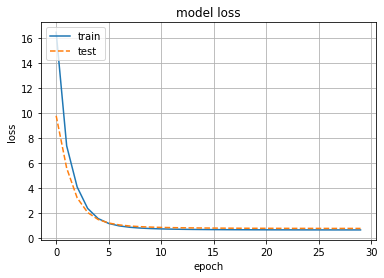

In [ ]:
# Plot pérdida de entrenamiento

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"], '--')
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
def recommend(user_id, train, test, df_items, df_aux):
  movies_watched_by_user = train[train.user == user_id]

  df_items_aux = df_items[['item']]
  df_items_aux['user'] = user_id
  movies_not_watched = pd.merge(df_items_aux, movies_watched_by_user, on=['user', 'item'], how='left')
  movies_not_watched = movies_not_watched[movies_not_watched.rating.isnull()][['user', 'item']]

  ratings = model.predict(movies_not_watched).flatten()
  movies_not_watched['predicted_rating'] = ratings
  top_ratings_items = movies_not_watched.sort_values(by='predicted_rating', ascending=False)

  print("Mostrar recomendaciones para el usuario: {}".format(user_id))
  print("====" * 9)
  print("Películas con altas valoraciones de los usuarios")
  print("----" * 8)

  movies_watched_by_user = pd.merge(movies_watched_by_user, df_aux, on=['item_id'])
  top_movies_user = movies_watched_by_user.sort_values(by='rating', ascending=False)[['user', 'item', 'rating', 'movie_title']]
  print(top_movies_user.head(20))

  print("====" * 9)
  print("Calificaciones de las películas vistas en los datos de prueba")
  print("----" * 8)
  movies_watched_by_user_test = test[test.user == user_id]
  movies_watched_by_user_test = pd.merge(movies_watched_by_user_test, df_aux, on=['item_id'])
  movies_watched_by_user_test = pd.merge(movies_watched_by_user_test, movies_not_watched, on=['user', 'item'])
  movies_user_test = movies_watched_by_user_test.sort_values(by='rating', ascending=False)[['user', 'item', 'rating', 'predicted_rating', 'movie_title']]
  print(movies_user_test.head(20))

  print("----" * 8)
  print("Top 10 recomendaciones de películas")
  print("----" * 8)
  top_movies_recommended = pd.merge(top_ratings_items, df_items, on=['item'])
  top_movies_recommended = pd.merge(top_movies_recommended, df_aux, on=['item_id'])
  print(top_movies_recommended[['item', 'predicted_rating', 'movie_title']].head(20))

In [ ]:
# Mostrar las 10 mejores recomendaciones de películas a un usuario

user_id = test.user.sample(1).iloc[0]
recommend(user_id, train, test, df_items, df_item_info)

# **AUTOENCODER**

In [ ]:
# ****************---------------******************-----------------------#
# ****************---------------******************-----------------------#
# MODELO DE FC DE DNN BASADO EN AUTOENCODERS (AutoRec)
class AutoRec(tf.keras.Model):
  def __init__(self, num_hidden, num_users, dropout=0.05, reg_enc=1e-2, reg_dec=1e-2):
    super(AutoRec, self).__init__()
    self.encoder = tf.keras.layers.Dense(num_hidden, activation='sigmoid',
                                         use_bias=True,
                                         kernel_regularizer=tf.keras.regularizers.l2(reg_enc))
    self.decoder = tf.keras.layers.Dense(num_users, use_bias=True,
                                         kernel_regularizer=tf.keras.regularizers.l2(reg_dec))
    self.dropout = tf.keras.layers.Dropout(dropout)

  def call(self, input, training=None):
    hidden = self.dropout(self.encoder(input))
    pred = self.decoder(hidden)
    return pred

In [ ]:
# Sistema métrico RMSE (FUNCION DE PERDIDA)

def autorec_rmse(y_true, y_pred):
  y_mask = tf.math.sign(y_true)
  squared_difference = tf.square(y_true - y_pred * y_mask)
  return tf.sqrt(tf.reduce_sum(squared_difference, axis=-1) / tf.math.maximum(tf.reduce_sum(y_mask, axis=-1), 1))

In [ ]:
# data

ae_data_train = train.groupby('user').agg({'item': list, 'rating': list}).reset_index()
ae_data_train['input'] = ae_data_train.apply(lambda x: np.squeeze(coo_matrix((x[2], (np.zeros_like(x[1]), x[1])),
                                                                  shape=(1, num_items)).toarray()),
                                             axis=1)
ae_data_train.head()

,user,item,rating,input
0,0,"[0, 3760, 4400, 1350, 8545, 8672, 2222, 5598, ...","[5, 3, 5, 5, 5, 4, 3, 5, 5, 3, 5, 4, 4, 4, 4, ...","[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[1, 139, 7121, 6197, 3152, 3410, 2961, 2363, 1...","[3, 3, 5, 5, 3, 3, 4, 3, 1, 4, 3, 5, 3, 5, 5, ...","[0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[2, 2200, 2405, 4334, 5373, 5376, 2903, 1352, ...","[4, 3, 4, 4, 3, 4, 4, 4, 3, 5, 4, 3, 4, 4, 5, ...","[0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"[3, 4427, 787, 5244, 4013, 264, 3846, 1982, 34...","[4, 4, 5, 5, 4, 3, 4, 3, 4, 4, 5, 3, 4, 3, 3, ...","[0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[584, 4, 546, 1875, 2282, 2293, 3419, 3897, 45...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, ..."


In [ ]:
x_train_autorec = ae_data_train.values[:, 3]
x_train_autorec = np.stack(x_train_autorec).astype(float)
x_train_autorec

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 4., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# test - validación
ae_data_test = test.groupby('user').agg({'item': list, 'rating': list}).reset_index()
ae_data_test['input'] = ae_data_test.apply(lambda x: np.squeeze(coo_matrix((x[2], (np.zeros_like(x[1]), x[1])),
                                                                shape=(1, num_items)).toarray()),
                                           axis=1)

ae_data_test_aux = pd.merge(ae_data_train, ae_data_test, on=['user'], how='inner')
x_test_autorec = np.stack(ae_data_test_aux.values[:, -1]).astype(float)
x_test_autorec

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# parámetros VARIAR VALORES
NUM_HIDDEN = 300
DROPOUT = 0.05
REG_ENC = 1e-2
REG_DEC = 1e-2

In [ ]:
model = AutoRec(NUM_HIDDEN, num_items, DROPOUT, REG_ENC, REG_DEC)
model.compile(loss=autorec_rmse,
              optimizer=tf.keras.optimizers.Adam(lr=1e-3))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(
    x_train_autorec,
    x_train_autorec,
    batch_size=128, # tamaño del entrenamiento por lotes
    epochs=1000,
    verbose=1,
    validation_data=(x_test_autorec, x_test_autorec))

Epoch 1/1000
70/70 [==============================] - 2s 26ms/step - loss: 5.0495 - val_loss: 3.7536
Epoch 2/1000
70/70 [==============================] - 1s 13ms/step - loss: 3.7536 - val_loss: 3.7128
Epoch 3/1000
70/70 [==============================] - 1s 13ms/step - loss: 3.7196 - val_loss: 3.6739
Epoch 4/1000
70/70 [==============================] - 1s 13ms/step - loss: 3.6830 - val_loss: 3.6444
Epoch 5/1000
70/70 [==============================] - 1s 13ms/step - loss: 3.6460 - val_loss: 3.6039
Epoch 6/1000
70/70 [==============================] - 1s 13ms/step - loss: 3.6105 - val_loss: 3.5638
Epoch 7/1000
70/70 [==============================] - 1s 13ms/step - loss: 3.5717 - val_loss: 3.5256
Epoch 8/1000
70/70 [==============================] - 1s 13ms/step - loss: 3.5338 - val_loss: 3.4898
Epoch 9/1000
70/70 [==============================] - 1s 13ms/step - loss: 3.4954 - val_loss: 3.4452
Epoch 10/1000
70/70 [==============================] - 1s 13ms/step - loss: 3.4573 - val_lo

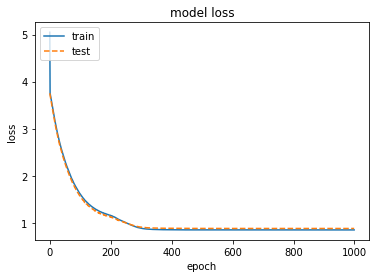

In [ ]:
# Plot pérdida de entrenamiento

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"], '--')
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# **Evaluación Recall@K**

In [ ]:
from collections import defaultdict

# un dict que almacena una lista de pares de valoraciones previstas y reales para cada usuario
user_est_true = defaultdict(list)

# iterar a través de los datos de validación para construir el usuario-> [(y1, y1_hat), (y2, y2_hat)...]
with torch.no_grad():
    for i, batched_data in enumerate(x_test_autorec):
        books = batched_data['books']
        users = batched_data['users']
        ratings = batched_data['ratings']

        model_output = model(batched_data['books'], batched_data["users"])

        for i in range(len(users)):
            book_id = books[i].item()
            user_id = users[i].item()
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()

            print(f"{book_id}, {user_id}, {pred_rating}, {true_rating}")
            user_est_true[user_id].append((pred_rating, true_rating))


IndexError: ignored

# **RECOMENDACION AUTOENCODER**

In [ ]:
def recommend_autorec(user_id, train, test, df_items, df_aux, num_items):
  movies_watched_by_user = train[train.user == user_id]

  df_items_aux = df_items[['item']]
  df_items_aux['user'] = user_id
  movies_not_watched = pd.merge(df_items_aux, movies_watched_by_user, on=['user', 'item'], how='left')
  movies_not_watched = movies_not_watched[movies_not_watched.rating.isnull()][['user', 'item']]

  df_input = movies_watched_by_user.groupby('user').agg({'item': list, 'rating': list}).reset_index()
  df_input['input'] = df_input.apply(lambda x: np.squeeze(coo_matrix((x[2], (np.zeros_like(x[1]), x[1])),
                                                          shape=(1, num_items)).toarray()),
                                     axis=1)

  x = np.stack(df_input.values[:, -1]).astype(float)
  ratings = model.predict(x).flatten()
  ratings_items = pd.DataFrame({'item': np.arange(num_items), 'predicted_rating': ratings})
  ratings_items = pd.merge(ratings_items, movies_not_watched, on=['item'], how='left')
  top_ratings_items = ratings_items[ratings_items.user.notnull()] \
    .sort_values(by='predicted_rating', ascending=False)[['item', 'predicted_rating']]

  print("Mostrar recomendaciones para el usuario: {}".format(user_id))
  print("====" * 9)
  print("Películas con altas valoraciones de los usuarios")
  print("----" * 8)

  movies_watched_by_user = pd.merge(movies_watched_by_user, df_aux, on=['item_id'])
  top_movies_user = movies_watched_by_user.sort_values(by='rating', ascending=False)[['user', 'item', 'rating', 'movie_title']]
  print(top_movies_user.head(20))

  print("====" * 9)
  print("Calificaciones de las películas vistas en los datos de prueba")
  print("----" * 8)
  movies_watched_by_user_test = test[test.user == user_id]
  movies_watched_by_user_test = pd.merge(movies_watched_by_user_test, df_aux, on=['item_id'])
  movies_watched_by_user_test = pd.merge(movies_watched_by_user_test, ratings_items, on=['user', 'item'])
  movies_user_test = movies_watched_by_user_test.sort_values(by='rating', ascending=False)[['user', 'item', 'rating', 'predicted_rating', 'movie_title']]
  print(movies_user_test.head(20))

  print("----" * 8)
  print("Top 10 recomendaciones de películas")
  print("----" * 8)
  top_movies_recommended = pd.merge(top_ratings_items, df_items, on=['item'])
  top_movies_recommended = pd.merge(top_movies_recommended, df_aux, on=['item_id'])
  print(top_movies_recommended[['item', 'predicted_rating', 'movie_title']].head(10))

In [ ]:
#Mostrar las 10 mejores recomendaciones de películas a un usuario

user_id = test.user.sample(1).iloc[0]
recommend_autorec(user_id, train, test, df_items, df_item_info, num_items)

NameError: ignored